# Purpose
Train autoencoder on MNIST dataset allowing variation of hidden layers in encoder/ decoder.

In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import time
import json

from typing import *
from tqdm import tqdm

In [3]:
# Setup
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("using device", device)
rng = torch.Generator().manual_seed(18065)

using device cuda:1


In [34]:
class Autoencoder(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        latent_dim: int,
        hidden_layers: int,
        residual_connection: bool = False,
    ):
        """
        Args:
            input_dim: int, input dimension
            hidden_dim: int, dimension of hidden layers
            latent_dim: int, dimension of latent space
            hidden_layers: int, number of hidden layers
            residual_connection: bool, whether to use residual connection in encoder/decoder
        """
        super(Autoencoder, self).__init__()
        assert hidden_layers > 0, "hidden_layers must be greater than 0"

        # observe this accounts for hidden_layers=1 properly
        layer_dims = [[hidden_dim, hidden_dim] for _ in range(hidden_layers)]
        layer_dims[0][0] = input_dim
        layer_dims[-1][1] = latent_dim

        encoder_layers = []
        for input_d, output_d in layer_dims:
            encoder_layers.append(nn.Linear(input_d, output_d))
            if output_d != latent_dim:
                encoder_layers.append(nn.ReLU())

        self.encoder_nn = nn.Sequential(*encoder_layers)

        decoder_layers = []
        for output_d, input_d in reversed(layer_dims):
            if input_d != latent_dim:
                decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Linear(input_d, output_d))

        self.decoder_nn = nn.Sequential(*decoder_layers)

        if residual_connection:
            self.encoder_residual = nn.Linear(input_dim, latent_dim)
            self.decoder_residual = nn.Linear(latent_dim, input_dim)
        else:
            self.encoder_residual = None
            self.decoder_residual = None

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        if self.encoder_residual is not None:
            x = self.encoder_residual(x) + self.encoder_nn(x)
        else:
            x = self.encoder_nn(x)
        return x

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        if self.decoder_residual is not None:
            z = self.decoder_residual(z) + self.decoder_nn(z)
        else:
            z = self.decoder_nn(z)
        return z

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        orig_shape = x.shape
        x = x.view(x.size(0), -1)
        x = self.encode(x)
        x = self.decode(x)
        x = x.view(orig_shape)
        return x

In [43]:
def load_dataset(name: str) -> tuple[torch.Tensor, torch.Tensor]:
    if name == "MNIST":
        # load data
        transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )
        # MNIST
        train_dataset = datasets.MNIST(
            root=".", train=True, transform=transform, download=True
        )
        test_dataset = datasets.MNIST(
            root=".", train=False, transform=transform, download=True
        )
    elif name == "SVHN":
        # load data
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        # SVHN
        train_dataset = datasets.SVHN(
            root=".", split="train", transform=transform, download=True
        )
        test_dataset = datasets.SVHN(
            root=".", split="test", transform=transform, download=True
        )
    elif name == "CIFAR10":
        # load data
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        # CIFAR10
        train_dataset = datasets.CIFAR10(
            root=".", train=True, transform=transform, download=True
        )
        test_dataset = datasets.CIFAR10(
            root=".", train=False, transform=transform, download=True
        )
    train_loader = DataLoader(
        train_dataset,
        batch_size=1024,
        shuffle=False,
        generator=rng,
        num_workers=128,
    )
    test_loader = DataLoader(
        test_dataset, batch_size=1024, shuffle=False, generator=rng, num_workers=128
    )

    all_train_data = []
    for data, _ in tqdm(train_loader):
        all_train_data.append(data)
    all_train_data = torch.concatenate(all_train_data).to(device)
    print(all_train_data.shape)

    all_valid_data = []
    for data, _ in tqdm(test_loader):
        all_valid_data.append(data)
    all_valid_data = torch.concatenate(all_valid_data).to(device)
    print(all_valid_data.shape)

    return all_train_data, all_valid_data

In [46]:
all_train_data, all_valid_data = load_dataset("CIFAR10")

100%|██████████| 170498071/170498071 [00:01<00:00, 104352294.16it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


100%|██████████| 49/49 [00:03<00:00, 14.19it/s]


torch.Size([50000, 3, 32, 32])


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

torch.Size([10000, 3, 32, 32])


Training

In [47]:
def train_and_get_results(
    dataset: tuple[torch.Tensor, torch.Tensor],
    model_kwargs: dict[str, Any],
    device: torch.device,
    checkpoint_func: Optional[Callable] = None,
    batch_size: int = 100,
    epochs: int = 100,
):
    model = Autoencoder(**model_kwargs).to(device)
    all_train_data, all_valid_data = dataset
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    start_time = time.time()
    epoch_data = {}
    for epoch in range(epochs):
        # Training loop
        train_loss = 0
        with torch.enable_grad():
            # Simulate dataloader shuffling
            permuted_data = torch.randperm(len(all_train_data), generator=rng)
            iters = len(all_train_data) // batch_size
            for i in range(iters):
                data = all_train_data[
                    permuted_data[i * batch_size : (i + 1) * batch_size]
                ]
                data = data.to(device)
                optimizer.zero_grad()

                output = model(data)

                loss = criterion(output, data)
                train_loss += loss.item()

                loss.backward()
                optimizer.step()
        scheduler.step()
        train_loss /= iters

        # Validation loop
        with torch.no_grad():
            output = model(all_valid_data)
            valid_loss = criterion(output, all_valid_data).item()

        epoch_data[epoch] = {
            "train_loss": train_loss,
            "valid_loss": valid_loss,
            "time_taken": time.time() - start_time,
        }

        if checkpoint_func is not None:
            checkpoint_func(model, epoch)

    return model, epoch_data

In [49]:
model, epoch_data = train_and_get_results(
    dataset=(all_train_data, all_valid_data),
    model_kwargs=dict(
        input_dim=all_train_data[0].numel(),
        hidden_dim=64,
        latent_dim=16,
        hidden_layers=2,
        residual_connection=False,
    ),
    device=device,
    batch_size=100,
    epochs=2,
)

torch.Size([5, 3, 32, 32])


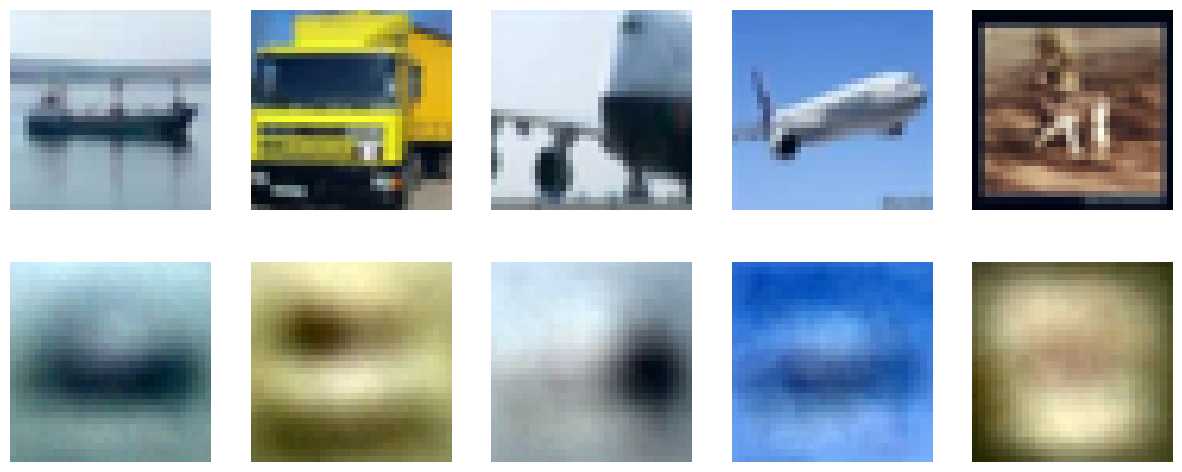

In [ ]:
# visualize reconstruction
gray_scale = len(all_train_data.shape) == 3
num_images = 5
sample_idx = torch.randint(0, len(all_train_data), (num_images,)).tolist()
sample_images = torch.stack([all_train_data[i] for i in sample_idx])
sample_images = sample_images.to(device)
print(sample_images.shape)

with torch.no_grad():
    reconstructed_images = model(sample_images)


# necessary for visualization; matplotlib expects values in [0, 1]
def normalize_image(image: torch.Tensor) -> torch.Tensor:
    return (image - image.min()) / (image.max() - image.min())


def get_image(image: torch.Tensor):
    if gray_scale:
        return normalize_image(image.cpu().numpy())
    else:
        return normalize_image(image.cpu().permute(1, 2, 0).numpy())


fig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 6), squeeze=False)
for i in range(num_images):
    axes[0, i].axis("off")
    axes[1, i].axis("off")
    axes[0, i].imshow(get_image(sample_images[i]), cmap="gray")
    axes[1, i].imshow(get_image(reconstructed_images[i]), cmap="gray")

plt.show()